# The preliminaries

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread, imshow

# Understanding the physics that produces a microscope image
A "raw" fluorescence micrograph image file is produced by three main physical effects:

1. Light-matter interaction (fluorescence)
2. Light diffraction in the microscope set up
3. Light detection and signal digitization by camera electronics

In today's lecture, we will examine the basics of the last two aspects. We will come back to fluorescence after a couple of lectures.


# Light detection and electronic imaging
Modern microscopes use two types of electronic imaging devices: (1) CCD and CMoS cameras, and (2) Photo-multiplier tubes (PMTs) and Avalanche photo-diodes (APDs). 

In both types of devices, there are three sub-systems: <br>(1) a light sensitive detector that absorbs photos and converts them into photo-electrons <br>
(2) Electronics that quantify the photo-electrons, i.e., the electric current generated by the photodetector<br>
(3) Electronics that digitize the photo-current to produce the final image

If you want to learn more about this topic, there are many online resources available. One of these is the MicroscopyU website maintained by Nikon. 


1.   [Introduction to CCD cameras](https://www.microscopyu.com/digital-imaging/introduction-to-charge-coupled-devices-ccds)
2.   [CCD Noise sources](https://www.microscopyu.com/tutorials/ccd-noise-sources)
3.   [CCD camera specification](https://github.com/ajitpj/IISER_2023/raw/main/Misc/L2/Andor_iXon_860_Specifications.pdf)



## The sequence of operations:

(1) **Detection**: The efficiency of conversion from photons to electrons, which is known as Quantum Efficiency, is a critical parameter. This parameter depends on the wavelength of light, which is especially important for fluorescence. The other parameter is how many photoelectrons each pixel can hold - the "full well capacity".<br>
(2) **Signal amplification**: Photons are almost scarce in fluorescence imaging. Therefore, signal amplifiers are a necessary features. These amplifiers have their own noise limitations, e.g., a typical amplifier will produce +/-5 electrons even in the absence of any light. Therefore, one can't be sure if there is a signal at the detector unless it exceeds 5 electrons (the noise floor). Therefore, the "signal unit" for the camera becomes this noise floor.<br>
(3) **Analog-to-digitcal conversion** - The final camera circuit converts the photocurrent into a digitcal count. The bit-depth for the AD convertor ultimately determines the number of intensity values that are represented in the image.

## Key CCD characteristics to remember
1. **Quantum efficiency** - the efficiency of converting photons into electrons
2. **Pixel size** - physical size of each pixel (important for image resolution)
3. **Full-well capacity** - maximum number of photons that can be stored in one pixel
4. **Dark current** - thermal noise
5. **Read-out noise** - noise introduced during the read-out process
6. **A/D converter resolution** - Number of gray levels detected
7. **Read-out frequency** - Number of pixels read in 1 second


## Excercise (3 min): Examine the specifications for the Orca camera. Do the full-well capacity, read noise, and the analog-to-digital bit numbers make sense to you?

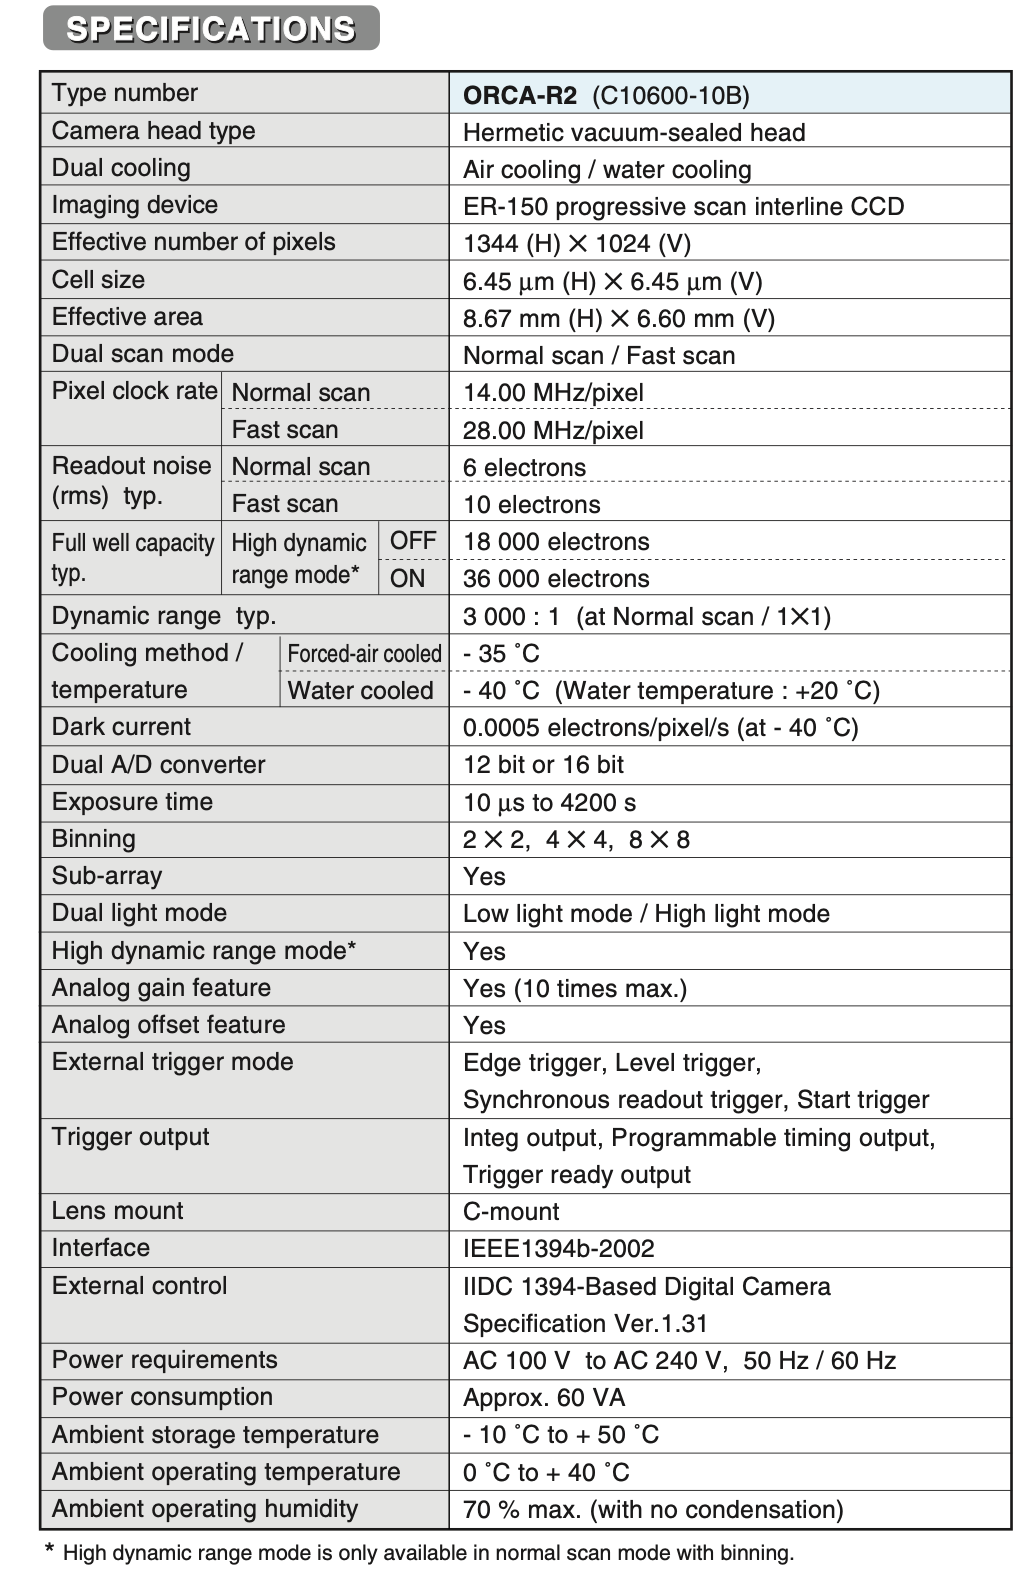

4096

## Examine the metadata stored with tiff files
I am using the tifffile library, which is designed to work efficiently with tiff files. The tiff file could either be a single image, or more typically, a multi-page file storing many image slices representing various dimensions of the image stack. 

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Colab Notebooks/IISER_2023/Images/L2/'

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/IISER_2023/Images/L2


In [ ]:
import tifffile

# The TiffFile function is used to open and read the metadata and data stored in 
# a tiff file. 
with tifffile.TiffFile('raw_img.tif') as tif:
  metadata = tif.pages[0]

# Instead of parsing the xml data, I am using the splitlines method for 
# python strings to make the metadata legible.
fileinfo = metadata.description.splitlines()
for line in fileinfo:
  print(line)

## Exercise (3 min): Examine camera dark noise characteristics
I took some dark images (no light falling on the camera light detector) on an Andor camera iXON897 camera that specifies the read noise for its amplifier to be 5 electrons. Can you confirm that the camera meets this specification using the dark images?

In [13]:
darkframes = imread('https://raw.githubusercontent.com/ajitpj/IISER_2023/main/Images/L2/14bit_1Mhz_5x_20ms_-68C.tif')

# Image formation in a microscope
This is a broad subject that needs it's own course. Here, we are going to touch on the basics, just enough to intuitively understand what you look at when you see a micrograph.

The most important characteristic of any light microscope is its **Point Spread function (PSF)**. This function (a mathematical formula) describes the image of a "point source" of light formed by the microscope. Imagine the sample - the cell, tissue, etc., as being made out of many point sources of light. The (wide-field) microscope will collect a small fraction of the light emitted by each point source and focus it into a PSF in the image. The image is thus the addition of all the PSFs (this process of addition of overlapping is described by the mathematical operation known as **convolution**).<br>

\begin{align}
PSF = \frac{1}{\sqrt{2\pi\sigma}}*\mathrm{e}^{\frac{-x^2}{2\sigma^2}}
\end{align}

Text(0.5, 1.0, 'Gaussian PSF')

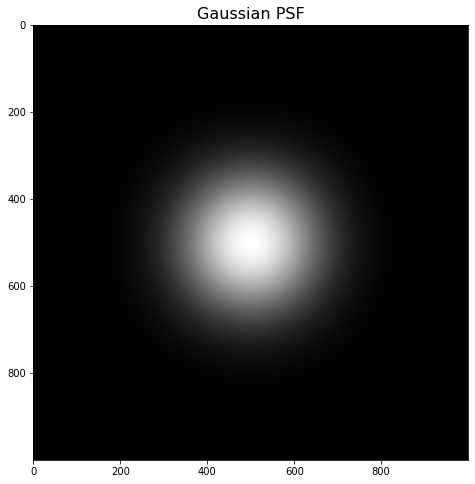

In [16]:
from scipy.signal import fftconvolve
import math
size = 1000
gauss_psf = np.zeros((size,size), dtype='float')
xv, yv = np.meshgrid(np.arange(0,size), np.arange(0,size))
center = size/2 # Center of the PSF
sigma  = 111 # Standard deviation of the Gaussian PSF
gauss_psf = (1/np.sqrt(2*math.pi*sigma)* \
             np.exp(-(center-xv)**2/(2*sigma**2))*np.exp(-(center-yv)**2/(2*sigma**2)))
f1 = plt.figure(figsize=(8, 8))
a1 = f1.subplots(1,1)
a1.imshow(gauss_psf, cmap='gray')
a1.set_title('Gaussian PSF', fontsize=16)



## Exercise (5 min): Place four point sources of light at the locations specified below. Construct the corresponding image using the principles discussed above.
(x1,y1) = (200,200)<br>
(x2,y2) = (200,800)<br>
(x3,y3) = (800,200)<br>
(x4,y4) = (800,800)<br>

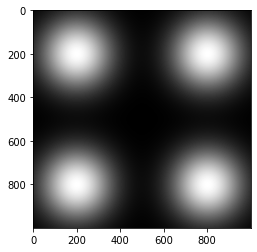

In [23]:
centers = np.array([[200,200],[200,800],[800,200],[800,800]])
xv, yv = np.meshgrid(np.arange(0,size), np.arange(0,size))
dark_img = np.zeros((1000,1000), dtype='float')
final_img = dark_img.copy()
for i in np.arange(0,4):
  centerx = centers[i,0]
  centery = centers[i,1]
  img = (1/np.sqrt(2*math.pi*sigma)* \
             np.exp(-(centerx-xv)**2/(2*sigma**2))*\
             np.exp(-(centery-yv)**2/(2*sigma**2)))
  final_img = final_img + img

  plt.imshow(final_img, cmap='gray')

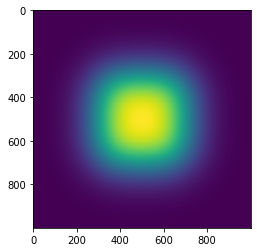

In [21]:
centers = np.array([[400,400],[400,600],[600,400],[600,600]])
xv, yv = np.meshgrid(np.arange(0,size), np.arange(0,size))
dark_img = np.zeros((1000,1000), dtype='float')
final_img = dark_img.copy()
for i in np.arange(0,4):
  centerx = centers[i,0]
  centery = centers[i,1]
  img = (1/np.sqrt(2*math.pi*sigma)* \
             np.exp(-(centerx-xv)**2/(2*sigma**2))*\
             np.exp(-(centery-yv)**2/(2*sigma**2)))
  final_img = final_img + img

  plt.imshow(final_img, cmap='gray')


# Spatial resolution in microscopy
The above exercise brings up to a seemingly hard limitation in light microscopy: the Abbe limit. Because of the large size of the PSF (compared to the point object), two objects that are close together beyond a certain limit cannot be 'resolved' using the light microscope. 

## Exercise (2 min): Plot the intensity profiles from the above to images to visualize how overlapping PSFs limit the resolution.

# Putting it all together
I hope that you now have a clearer idea of how a microscope image forms and how it is captured by electronic cameras. You can think of the image as being made up of several layers.<br>
1. The camera floor - an arbitrary positive value to ensure that all pixels have positive values.
2. Readout noise
3. Background signal - produced by light scattering in the lenses, filters, etc., as well as fluorescence produced by unlabeled stuff.
4. the actual signal - This is what we wanted to visualize to begin with
5. Shot noise - 'Poisson noise' proportioal to the square root of the signal